# Risk Premia Harvesting - Buy & Hold Strategy with Monthly Rebalancing

## Overview

This notebook implements a buy-and-hold strategy with monthly rebalancing to harvest risk premia from a diversified portfolio. Unlike a pure buy-and-hold approach, this strategy rebalances the portfolio back to target weights at the end of each month, ensuring consistent risk exposure throughout the investment period (approximately 10 years).

**Portfolio Composition:**
- SPY (S&P 500 ETF): 50%
- TLT (Long-term Treasury ETF): 35%
- GLD (Gold ETF): 15%

**Initial Capital:** $10,000.00

**Rebalancing Frequency:** Monthly (end of month)

## Target Outputs

### Performance Metrics
- Annualized Return
- Annualized Volatility
- Sharpe Ratio
- Maximum Drawdown

### Visualizations
- Equity curves (total portfolio and individual assets)
- 1-year rolling annualized return
- 1-year rolling annualized volatility
- 1-year rolling Sharpe ratio

## Implementation Steps

### 1. Data Acquisition
Load historical price data for SPY, TLT, and GLD

### 2. Data Preparation
   1. Remove rows with missing data
   2. Ensure all tickers share the same date index
   3. Identify month-end dates for rebalancing events

### 3. Portfolio Initialization
   1. Set initial capital and target asset weights
   2. Select the first trading date
   3. Calculate dollar allocation per asset based on target weights
   4. Determine the number of shares for each asset

### 4. Equity Curve Construction with Monthly Rebalancing
   1. Calculate daily equity for each asset based on current holdings
   2. Compute total portfolio equity daily
   3. At each month-end:
      - Calculate current portfolio value
      - Rebalance: adjust share quantities to match target weights
      - Update holdings for the next period
   4. Consolidate results into a unified DataFrame

### 5. Returns Calculation
   1. Compute portfolio daily returns
   2. Compute individual asset daily returns

### 6. Performance Statistics
   1. Calculate annualized return
   2. Calculate annualized volatility
   3. Calculate Sharpe ratio
   4. Calculate maximum drawdown

### 7. Static Visualizations
Plot all equity curves on a single chart

### 8. Rolling Performance Analysis
   1. Generate rolling 1-year annualized return chart
   2. Generate rolling 1-year annualized volatility chart
   3. Generate rolling 1-year Sharpe ratio chart

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Acquisition

spy_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_SPY.csv", index_col=0, parse_dates=True)
tlt_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_TLT.csv", index_col=0, parse_dates=True)
gld_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_GLD.csv", index_col=0, parse_dates=True)

# 2. Data Preparation

# Combine all returns into a single DataFrame
close_df = pd.DataFrame({
    'SPY': spy_returns['Close'],
    'TLT': tlt_returns['Close'],
    'GLD': gld_returns['Close']
})

# Drop rows with any missing data
close_df = close_df.dropna()

# Identify month-end dates for rebalancing
month_end_dates = close_df.resample('ME').last().index

# Create a boolean column to mark rebalancing dates
close_df['is_rebalance_date'] = close_df.index.isin(month_end_dates)

In [6]:
# 3. Portfolio Initialization

# Set initial capital and asset weights
initial_capital = 10000.00
weights = {
    'SPY': 0.50,
    'TLT': 0.35,
    'GLD': 0.15
}

# Select the first trading date
first_date = close_df.index[0]
print(f"First trading date: {first_date}")

# Calculate dollar allocation per asset
allocations = {
    'SPY': initial_capital * weights['SPY'],
    'TLT': initial_capital * weights['TLT'],
    'GLD': initial_capital * weights['GLD']
}

print(f"\nDollar allocations:")
for ticker, amount in allocations.items():
    print(f"  {ticker}: ${amount:,.2f}")

# Get initial prices
initial_prices = close_df.loc[first_date]
print(f"\nInitial prices on {first_date}:")
for ticker, price in initial_prices.items():
    print(f"  {ticker}: ${price:.2f}")

# Determine the number of shares for each asset
shares = {
    'SPY': allocations['SPY'] / initial_prices['SPY'],
    'TLT': allocations['TLT'] / initial_prices['TLT'],
    'GLD': allocations['GLD'] / initial_prices['GLD']
}

print(f"\nNumber of shares purchased:")
for ticker, num_shares in shares.items():
    print(f"  {ticker}: {num_shares:.4f} shares")

# Calculate actual invested amount (accounting for fractional shares)
total_invested = sum(shares[ticker] * initial_prices[ticker] for ticker in shares.keys())
print(f"\nTotal invested: ${total_invested:,.2f}")

First trading date: 2015-01-05 00:00:00

Dollar allocations:
  SPY: $5,000.00
  TLT: $3,500.00
  GLD: $1,500.00

Initial prices on 2015-01-05 00:00:00:
  SPY: $168.00
  TLT: $96.97
  GLD: $115.80
  is_rebalance_date: $0.00

Number of shares purchased:
  SPY: 29.7612 shares
  TLT: 36.0941 shares
  GLD: 12.9534 shares

Total invested: $10,000.00


In [12]:
# 4. Equity Curve Construction with Monthly Rebalancing

# Initialize tracking dictionaries
current_shares = shares.copy()
equity_data = []

# Iterate through each date
for date in close_df.index:
    # Get current prices
    current_prices = close_df.loc[date, ['SPY', 'TLT', 'GLD']]
    
    # Calculate daily equity for each asset based on current holdings
    spy_equity = current_shares['SPY'] * current_prices['SPY']
    tlt_equity = current_shares['TLT'] * current_prices['TLT']
    gld_equity = current_shares['GLD'] * current_prices['GLD']
    
    # Compute total portfolio equity daily
    total_equity = spy_equity + tlt_equity + gld_equity
    
    # Store the equity values
    equity_data.append({
        'Date': date,
        'SPY_equity': spy_equity,
        'TLT_equity': tlt_equity,
        'GLD_equity': gld_equity,
        'total_equity': total_equity
    })
    
    # At each month-end: rebalance
    if close_df.loc[date, 'is_rebalance_date']:
        # Calculate current portfolio value
        portfolio_value = total_equity
        
        # Rebalance: adjust share quantities to match target weights
        current_shares['SPY'] = (portfolio_value * weights['SPY']) / current_prices['SPY']
        current_shares['TLT'] = (portfolio_value * weights['TLT']) / current_prices['TLT']
        current_shares['GLD'] = (portfolio_value * weights['GLD']) / current_prices['GLD']

# Consolidate results into a unified DataFrame
equity_df = pd.DataFrame(equity_data)
equity_df.set_index('Date', inplace=True)

# 5. Returns Calculation

# Compute portfolio daily returns
returns_df = pd.DataFrame(index=close_df.index)
returns_df['portfolio_return'] = equity_df['total_equity'].pct_change()

# Compute individual asset daily returns
returns_df['SPY_return'] = equity_df['SPY_equity'].pct_change()
returns_df['TLT_return'] = equity_df['TLT_equity'].pct_change()
returns_df['GLD_return'] = equity_df['GLD_equity'].pct_change()

# Drop the first row (NaN due to pct_change)
returns_df = returns_df.dropna()

# 6. Performance Statistics

# Assume 252 trading days per year
trading_days = 252

# Calculate annualized return
total_return = (equity_df['total_equity'].iloc[-1] / equity_df['total_equity'].iloc[0]) - 1
num_years = len(returns_df) / trading_days
annualized_return = (1 + total_return) ** (1 / num_years) - 1

# Calculate annualized volatility
annualized_volatility = returns_df['portfolio_return'].std() * np.sqrt(trading_days)

# Calculate Sharpe ratio (assuming 0% risk-free rate)
risk_free_rate = 0.0
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
cumulative_returns = (1 + returns_df['portfolio_return']).cumprod()
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()

# Display equity curve summary
print("=" * 50)
print("EQUITY CURVE SUMMARY")
print("=" * 50)
print(f"Initial portfolio value: ${equity_df['total_equity'].iloc[0]:,.2f}")
print(f"Final portfolio value: ${equity_df['total_equity'].iloc[-1]:,.2f}")
print(f"Total return: ${equity_df['total_equity'].iloc[-1] - equity_df['total_equity'].iloc[0]:,.2f}")
print(f"Total return %: {((equity_df['total_equity'].iloc[-1] / equity_df['total_equity'].iloc[0]) - 1) * 100:.2f}%")
print("\n")

# Display results
print("=" * 50)
print("PORTFOLIO PERFORMANCE STATISTICS")
print("=" * 50)
print(f"Period: {equity_df.index[0].strftime('%Y-%m-%d')} to {equity_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of years: {num_years:.2f}")
print(f"\nAnnualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

EQUITY CURVE SUMMARY
Initial portfolio value: $10,000.00
Final portfolio value: $24,517.17
Total return: $14,517.17
Total return %: 145.17%


PORTFOLIO PERFORMANCE STATISTICS
Period: 2015-01-05 to 2025-11-19
Number of years: 10.86

Annualized Return: 8.61%
Annualized Volatility: 9.99%
Sharpe Ratio: 0.8621
Maximum Drawdown: -25.34%


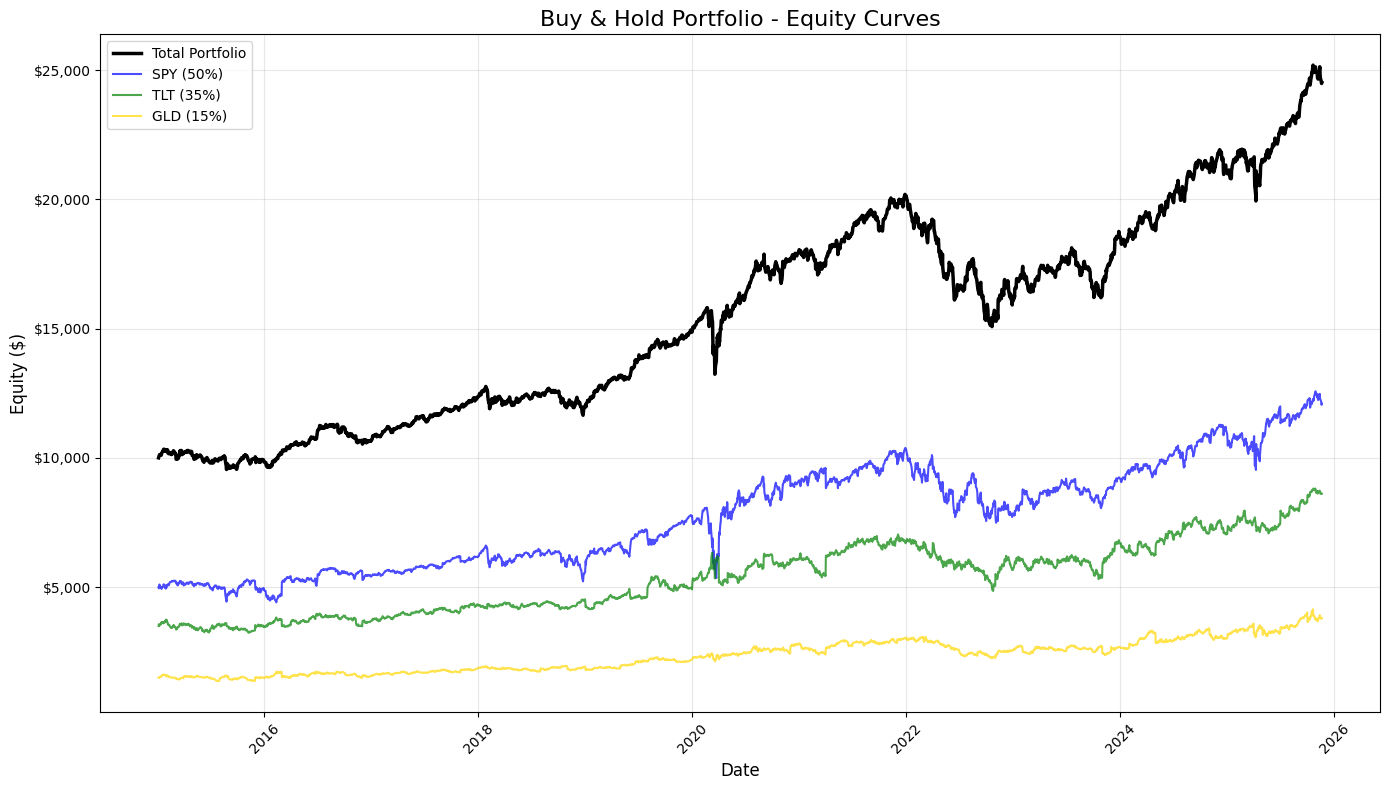

In [13]:
# 7. Static Visualizations

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot equity curves
ax.plot(equity_df.index, equity_df['total_equity'], label='Total Portfolio', linewidth=2.5, color='black')
ax.plot(equity_df.index, equity_df['SPY_equity'], label='SPY (50%)', linewidth=1.5, alpha=0.7, color='blue')
ax.plot(equity_df.index, equity_df['TLT_equity'], label='TLT (35%)', linewidth=1.5, alpha=0.7, color='green')
ax.plot(equity_df.index, equity_df['GLD_equity'], label='GLD (15%)', linewidth=1.5, alpha=0.7, color='gold')

# Formatting
ax.set_title('Buy & Hold Portfolio - Equity Curves', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity ($)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

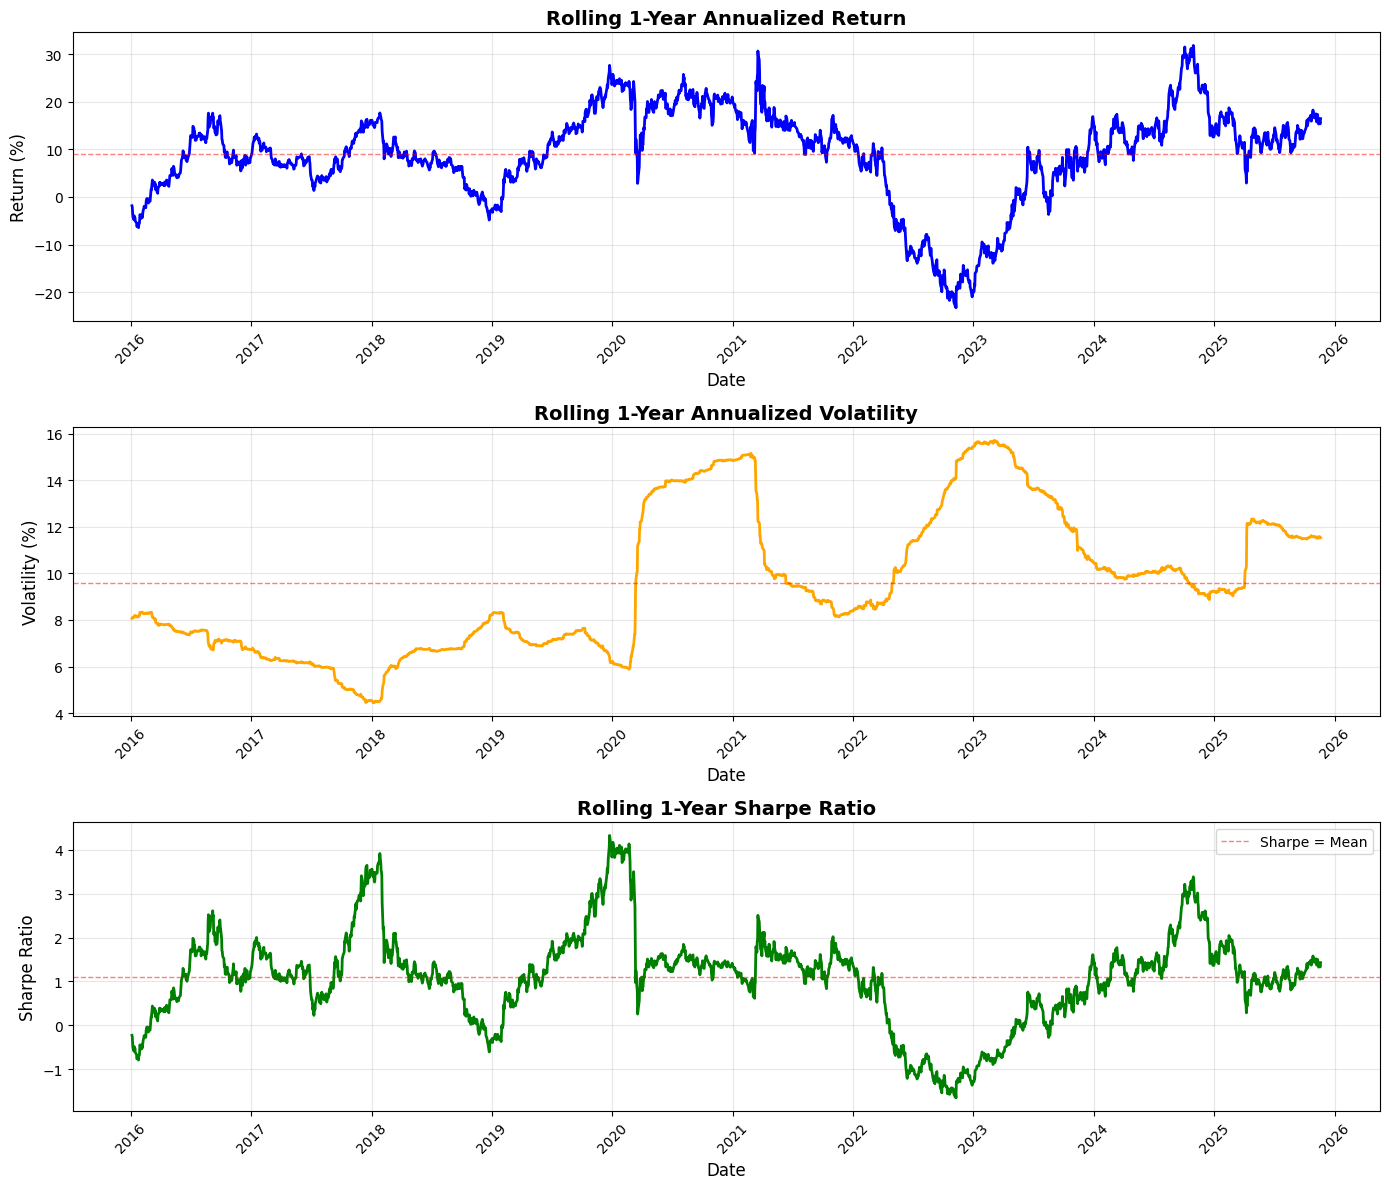


ROLLING METRICS SUMMARY (1-YEAR WINDOW)

Rolling Annualized Return:
  Mean: 9.01%
  Min:  -23.29%
  Max:  31.86%

Rolling Annualized Volatility:
  Mean: 9.59%
  Min:  4.44%
  Max:  15.71%

Rolling Sharpe Ratio:
  Mean: 1.0933
  Min:  -1.6518
  Max:  4.3269


In [14]:
# 8. Rolling Performance Analysis

# Define rolling window (252 trading days = 1 year)
window = 252

# Calculate rolling metrics
rolling_return = returns_df['portfolio_return'].rolling(window=window).apply(
    lambda x: (1 + x).prod() ** (252 / len(x)) - 1
)

rolling_volatility = returns_df['portfolio_return'].rolling(window=window).std() * np.sqrt(252)

rolling_sharpe = rolling_return / rolling_volatility

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Rolling 1-Year Annualized Return
axes[0].plot(rolling_return.index, rolling_return * 100, linewidth=2, color='blue')
axes[0].axhline(y=rolling_return.mean() * 100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Return = Mean')
axes[0].set_title('Rolling 1-Year Annualized Return', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Return (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Date', fontsize=12)

# 2. Rolling 1-Year Annualized Volatility
axes[1].plot(rolling_volatility.index, rolling_volatility * 100, linewidth=2, color='orange')
axes[1].axhline(y=rolling_volatility.mean() * 100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Volatility = Mean')
axes[1].set_title('Rolling 1-Year Annualized Volatility', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Date', fontsize=12)

# 3. Rolling 1-Year Sharpe Ratio
axes[2].plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='green')
axes[2].axhline(y=rolling_sharpe.mean(), color='red', linestyle='--', linewidth=1, alpha=0.5, label='Sharpe = Mean')
axes[2].set_title('Rolling 1-Year Sharpe Ratio', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Sharpe Ratio', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].legend(loc='best', fontsize=10)

# Format x-axis for all subplots
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics for rolling metrics
print("\n" + "=" * 50)
print("ROLLING METRICS SUMMARY (1-YEAR WINDOW)")
print("=" * 50)
print("\nRolling Annualized Return:")
print(f"  Mean: {rolling_return.mean():.2%}")
print(f"  Min:  {rolling_return.min():.2%}")
print(f"  Max:  {rolling_return.max():.2%}")

print("\nRolling Annualized Volatility:")
print(f"  Mean: {rolling_volatility.mean():.2%}")
print(f"  Min:  {rolling_volatility.min():.2%}")
print(f"  Max:  {rolling_volatility.max():.2%}")

print("\nRolling Sharpe Ratio:")
print(f"  Mean: {rolling_sharpe.mean():.4f}")
print(f"  Min:  {rolling_sharpe.min():.4f}")
print(f"  Max:  {rolling_sharpe.max():.4f}")
print("=" * 50)